In [ ]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Load the dataset using “ torchvision.datasets” library,preprocess the dataset using “torchvision.transforms” library and finally create a train loader and test loader of some batch size using “torch.utils.data” library.

In [ ]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

# mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [ ]:
dataiter = iter(dataloader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


**Create an autoencoder class with decoder and encoder architecture and a hidden neuron representation.**

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),  
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [ ]:
criterion = nn.MSELoss()
model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
# outputs = []

***Training loop***

In [ ]:
def train_data(num_epochs):
    # num_epochs = 1
    
    outputs = []
    train_losses = []
    for epoch in range(num_epochs):
        train_loss=0.0
        for (img, _) in dataloader:
            # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
            recon = model(img)
            loss = criterion(recon, img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
        outputs.append((epoch, img, recon))
        train_losses.append(train_loss)
    return outputs, train_losses

**Testing Loop**

In [ ]:
def test_Data():
    total_loss = 0

    for batch in testloader:
        img, _ = batch
        recon = model(img)
        loss = criterion(recon, img)
        total_loss += loss.item()

    return total_loss

In [ ]:
def plot(losses, num_epochs, modelname):
    epochs = range(1,num_epochs+1)
    plt.plot(epochs, losses, 'g', label='Training loss')
    plt.title('Training loss vs Epochs' + modelname)
    plt.xlabel('Epochs')
    plt.ylabel('Training loss' )
    plt.legend()
    plt.show()

**experiment using different optimizers**

Epoch:1, Loss:0.0090
Epoch:2, Loss:0.0053
Epoch:3, Loss:0.0041
Epoch:4, Loss:0.0038
Epoch:5, Loss:0.0029
Epoch:6, Loss:0.0031
Epoch:7, Loss:0.0028
Epoch:8, Loss:0.0029
Epoch:9, Loss:0.0025
Epoch:10, Loss:0.0029


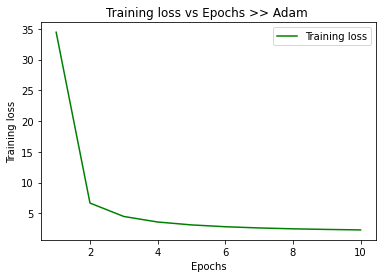

In [ ]:
# Adam
num_epochs=10
output_adm,train_losses_adm = train_data(num_epochs)
plot(train_losses_adm, num_epochs, " >> Adam ")

In [ ]:
def plot_reconstructed_image(model_output):

    for k in range(0, num_epochs, 4):
        plt.figure(figsize=(9, 2))
        plt.gray()
        imgs = model_output[k][1].detach().numpy()
        recon = model_output[k][2].detach().numpy()
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i+1)
            plt.imshow(item[0])
                
        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9+i+1) # row_length + i + 1
            plt.imshow(item[0])


In [ ]:
loss_Adam = test_Data()
print ("adam : ", loss_Adam)

adam :  0.3730909952428192


Epoch:1, Loss:0.2182
Epoch:2, Loss:0.1870
Epoch:3, Loss:0.1636
Epoch:4, Loss:0.1513
Epoch:5, Loss:0.1387
Epoch:6, Loss:0.1328
Epoch:7, Loss:0.1225
Epoch:8, Loss:0.1182
Epoch:9, Loss:0.1211
Epoch:10, Loss:0.1114


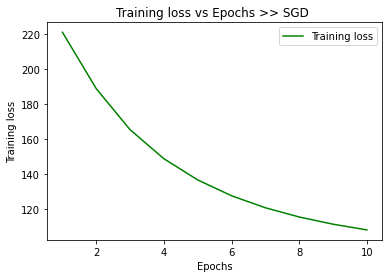

loss_SGD :  18.000061593949795


In [ ]:
# SGD
num_epochs = 10
model = Autoencoder()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
output_sgd, train_losses_sgd = train_data(num_epochs)
plot(train_losses_sgd, num_epochs, " >> SGD ")
loss_SGD = test_Data()
print ("loss_SGD : ", loss_SGD)

Epoch:1, Loss:0.0103
Epoch:2, Loss:0.0066
Epoch:3, Loss:0.0048
Epoch:4, Loss:0.0042
Epoch:5, Loss:0.0038
Epoch:6, Loss:0.0032
Epoch:7, Loss:0.0022
Epoch:8, Loss:0.0028
Epoch:9, Loss:0.0031
Epoch:10, Loss:0.0025


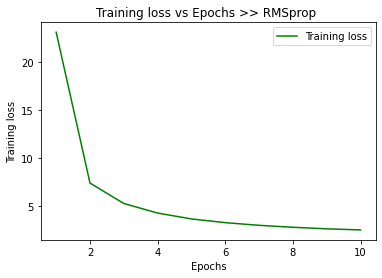

loss_RMSprop :  0.41572872595861554


In [ ]:
# RMSprop
model = Autoencoder()
optimizer = torch.optim.RMSprop(model.parameters(),lr=1e-3)
output_RMSprop, train_losses_RMSprop = train_data(num_epochs)
plot(train_losses_RMSprop, num_epochs, " >> RMSprop ")
loss_RMSprop = test_Data()
print ("loss_RMSprop : ", loss_RMSprop)

Epoch:1, Loss:0.1146
Epoch:2, Loss:0.1024
Epoch:3, Loss:0.1020
Epoch:4, Loss:0.0927
Epoch:5, Loss:0.1028
Epoch:6, Loss:0.0931
Epoch:7, Loss:0.0970
Epoch:8, Loss:0.0927
Epoch:9, Loss:0.1049
Epoch:10, Loss:0.0903


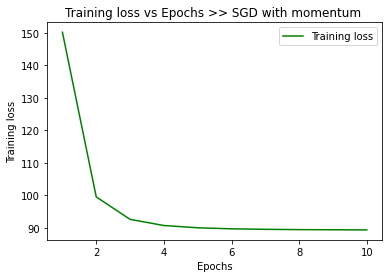

loss_SGD_with_momentum :  15.18079473823309


In [ ]:
# SGD with momentum
model = Autoencoder()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3, momentum=0.9)
output_sgd_with_momentum, train_losses_sgd_momentum = train_data(num_epochs)
plot(train_losses_sgd_momentum, num_epochs, " >> SGD with momentum ")
loss_SGD_with_momentum = test_Data()
print ("loss_SGD_with_momentum : ", loss_SGD_with_momentum)

**save the best performing model using “torch.save”**

In [ ]:
# saving best model : 
PATH = "state_dict_model.pt"
torch.save(model_adam.state_dict(), PATH)

**Plotting reconstructed image VS actual image using best observed optimizers : Adam and RMSProp**

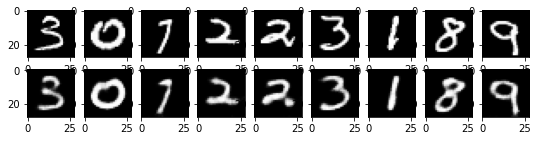

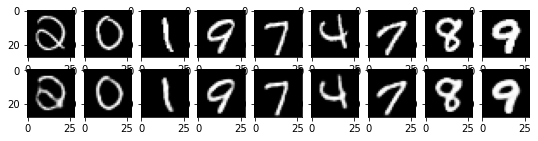

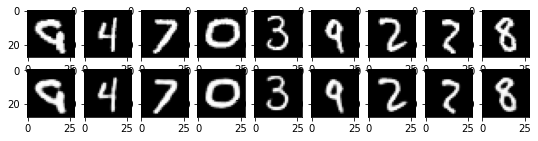

In [ ]:
plot_reconstructed_image(output_adm)

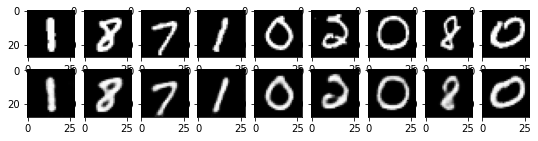

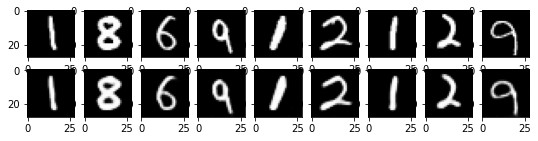

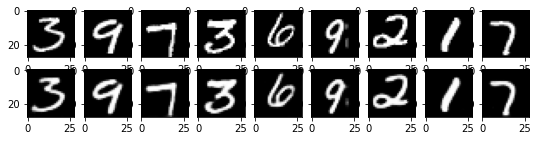

In [ ]:
plot_reconstructed_image(output_RMSprop)

**2) Plot the test reconstruction loss vs hidden neurons for all the above optimizers.**

In [ ]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self, last_layer):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, last_layer) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(last_layer, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
def training(num_epochs):
    outputs = []
    for epoch in range(num_epochs):
        for (img, _) in dataloader:
            img = img.reshape(-1, 28*28)
            recon = model(img)
            loss = criterion(recon, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
        outputs.append((epoch, img, recon))

In [ ]:
def test_image():
    total_loss = 0.0
    for (img, _) in testloader:
        img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = criterion(recon, img)
        total_loss += loss.item()

    return total_loss

**Testing on different number of nuerons in bottleneck layer**

In [ ]:
n_last_layers = 3
num_epochs=2
model = Autoencoder_Linear(n_last_layers)
optimizer = torch.optim.RMSprop(model.parameters(),lr=1e-3)
training(num_epochs)
linear_loss_RMSprop_3 = test_image()
print ("linear_loss_RMSprop_3 : ", linear_loss_RMSprop_3)

Epoch:1, Loss:0.0449
Epoch:2, Loss:0.0373
linear_loss_RMSprop_3 :  6.143448024988174


In [ ]:
n_last_layers = 10
num_epochs=2
model = Autoencoder_Linear(n_last_layers)
optimizer = torch.optim.RMSprop(model.parameters(),lr=1e-3)
training(num_epochs)
linear_loss_RMSprop_10 = test_image()
print ("linear_loss_RMSprop_10 : ", linear_loss_RMSprop_10)

Epoch:1, Loss:0.0411
Epoch:2, Loss:0.0340
linear_loss_RMSprop_10 :  5.078837160021067


In [ ]:
n_last_layers = 16
num_epochs=2
model = Autoencoder_Linear(n_last_layers)
optimizer = torch.optim.RMSprop(model.parameters(),lr=1e-3)
training(num_epochs)
linear_loss_RMSprop_16 = test_image()
print ("linear_loss_RMSprop_16 : ", linear_loss_RMSprop_16)

Epoch:1, Loss:0.0379
Epoch:2, Loss:0.0295
linear_loss_RMSprop_16 :  5.114915505051613


In [ ]:
n_last_layers = 32
num_epochs=2
model = Autoencoder_Linear(n_last_layers)
optimizer = torch.optim.RMSprop(model.parameters(),lr=1e-3)
training(num_epochs)
linear_loss_RMSprop_32 = test_image()
print ("linear_loss_RMSprop_32 : ", linear_loss_RMSprop_32)

Epoch:1, Loss:0.0449
Epoch:2, Loss:0.0324
linear_loss_RMSprop_32 :  4.972591076046228


In [ ]:
n_last_layers = 64
num_epochs=2
model = Autoencoder_Linear(n_last_layers)
optimizer = torch.optim.RMSprop(model.parameters(),lr=1e-3)
training(num_epochs)
linear_loss_RMSprop_64 = test_image()
print ("linear_loss_RMSprop_64 : ", linear_loss_RMSprop_64)

Epoch:1, Loss:0.0447
Epoch:2, Loss:0.0386
linear_loss_RMSprop_64 :  5.730181420221925


Plot the test reconstruction loss vs hidden neurons

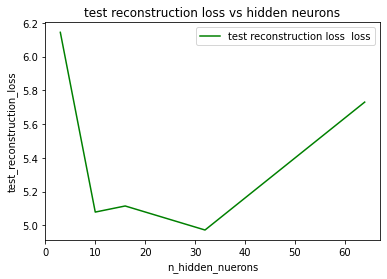

In [ ]:
n_hidden_nuerons = [3,10,16,32,64]
test_reconstruction_loss = [linear_loss_RMSprop_3, linear_loss_RMSprop_10, linear_loss_RMSprop_16, linear_loss_RMSprop_32, linear_loss_RMSprop_64]
plt.plot(n_hidden_nuerons, test_reconstruction_loss, 'g', label='test reconstruction loss  loss')
plt.title('test reconstruction loss vs hidden neurons')
plt.xlabel('n_hidden_nuerons')
plt.ylabel('test_reconstruction_loss')
plt.legend()
plt.show()

**3) Perform PCA reconstruction and compare with the Autoencoder reconstruction using test reconstruction loss (you can use inbuilt PCA).**

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

import math

In [ ]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [ ]:
train_y.shape

(60000,)

In [ ]:
newtrain_X = train_X.reshape(-1, 784)
newtest_X = test_X.reshape(-1, 784)

In [ ]:
train_x = newtrain_X/255.0
test_x = newtest_X/255.0

In [ ]:
n_components = 120
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(train_x)
test_x_pca = pca.transform(test_x)

In [ ]:
def reconstruction(X, n, trans):
    vectors = [trans.components_[n] * X[n] for n in range(0, n)]
    ret = trans.inverse_transform(X)
    ret[ret < 0] = 0
    ret[ret > 1] = 1
    return ret

**Actual Image VS Reconstructed Image**

(0.0, 28.0, 28.0, 0.0)

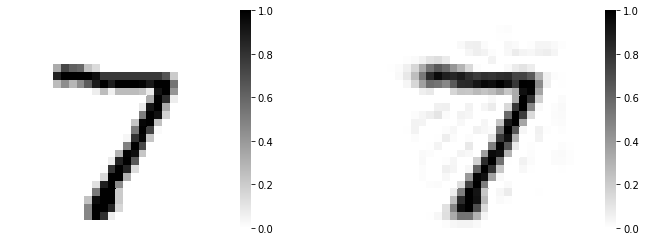

In [ ]:
import seaborn as sns
fig, axarr = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(test_x[0, :].reshape(28, 28), cmap='gray_r',ax=axarr[0])
sns.heatmap(reconstruction(test_x_pca[0, :], 120, pca).reshape(28, 28), cmap='gray_r',
            ax=axarr[1])
axarr[0].set_aspect('equal')
axarr[0].axis('off')
axarr[1].set_aspect('equal')
axarr[1].axis('off')

In [ ]:
ret = reconstruction(test_x_pca[0, :], 120, pca)

In [ ]:
test_x[0].shape

(784,)

In [ ]:
import numpy as np
Y = np.square(np.subtract(ret,test_x[0])).mean()
print("MSE:", Y)

MSE: 0.002265281581378457


In [ ]:
test_reconstruction_loss=0.0
for i in range(test_x.shape[0]):
    recons = reconstruction(test_x_pca[i, :], 120, pca)
    actual = test_x[i]
    loss = np.square(np.subtract(recons,actual)).mean() 
    test_reconstruction_loss += loss
                                                                     

In [ ]:
print(" test_reconstruction_loss : ", test_reconstruction_loss )

 test_reconstruction_loss :  37.148806918914296


**Comparison**

test_reconstruction_loss of Autoencoder (using Adam model) :  0.3730909952428192
> 
test_reconstruction_loss of PCA:  37.148806918914296
> 
We observe that the Autoencoder outperforms PCA in this case
